## Red Neuronal (2 capas), desde cero

### Importar librerías

In [2]:
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 


from get_images import get_images

### Importar MNIST 

<img src="images_global\mnist_plot.png">

<caption><left> Fig 1. Muestra MNIST </left></caption>


In [3]:
mnist_path = './mnist_raw'

In [4]:
x_train_num, y_train_num, x_test_num, y_test_num = get_images(path=mnist_path)

In [5]:
print(x_train_num.shape)
print(x_test_num.shape)
print(x_train_num[:50000].shape)

(60000, 28, 28)
(10000, 28, 28)
(50000, 28, 28)


### Convertir imágenes en vectores, y a float32

In [6]:
# set de entrenamiento
x_train = x_train_num[:50000].reshape(50000, -1).astype(np.float32)/255 # el -1 es la resultante de multiplicar 28x28
y_train = y_train_num[:50000].reshape(50000, 1) # selecciono 50000 en una sola columna

# set de validación
x_val = x_train_num[50000:].reshape(10000, -1).astype(np.float32)/255
y_val = y_train_num[50000:].reshape(10000, 1)

# set de prueba
x_test = x_test_num.copy().reshape(10000, -1).astype(np.float32)/255
y_test = y_test_num.copy().reshape(10000, 1)

# fomas de los set de datos
print(x_train.shape)
print(y_train.shape)

print(x_val.shape)
print(y_val.shape)

print(x_test.shape)
print(y_test.shape)

(50000, 784)
(50000, 1)
(10000, 784)
(10000, 1)
(10000, 784)
(10000, 1)


### Graficar algunas imágenes

In [7]:
def plot_number(image: str) -> None:
    plt.imshow(image.squeeze(), cmap=plt.get_cmap('gray'))
    plt.axis('off')
    plt.show()

La imagen muestreada representa un: [0]


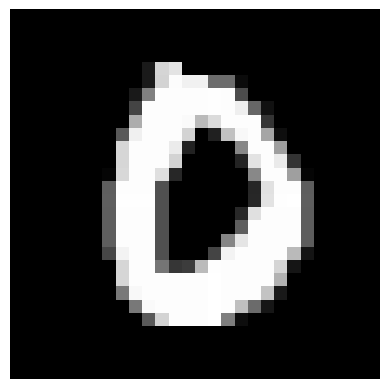

In [8]:
rnd_idx = np.random.randint(len(y_test))
print(f'La imagen muestreada representa un: {y_test[rnd_idx]}')
plot_number(x_test_num[rnd_idx])

### Ecuaciones para nuestro modelo


$$z^1 = W^1 X + b^1$$

$$a^1 = ReLU(z^1) $$

$$z^2 = W^2 a^1 + b^2$$

$$\hat{y} = \frac{e^{z^{2_k}}}{\sum_j{e^{z_j}}}$$


$$ \mathcal{L}(\hat{y}^{i}, y^{i}) =  - y^{i}  \ln(\hat{y}^{i}) = -\ln(\hat{y}^i)$$


$$ \mathcal{J}(w, b) =  \frac{1}{num\_samples} \sum_{i=1}^{num\_samples}-\ln(\hat{y}^{i})$$



### Red Neuronal Dos capas 200-10

### Crear 'Mini-batches'

In [9]:
print(x_train.shape[0])
print(y_train.shape[0])

50000
50000


In [10]:
def create_minibatches(mb_size, x, y, shuffle = True):
    '''
    mb_size = numero de elementos en cada minibatch
    x = (numero muestras, 784), corresponde a x_train o el total de elementos para hacer minibatches
    y = (numero muestras, 1), corresponde al numro de etiquetas de ese dataset, seria y_train
    shuffle = permite hacer un muestreo aleatorio de los datos
    '''
    assert x.shape[0] == y.shape[0], 'Error en cantidad de muestras' #chequea que la forma de x e y sean las mismas
    total_data = x.shape[0]
    if shuffle: 
        idxs = np.arange(total_data)
        np.random.shuffle(idxs)
        x = x[idxs]
        y = y[idxs]
        
    return ((x[i:i+mb_size], y[i:i+mb_size]) for i in range(0, total_data, mb_size))

### Init parameters

In [11]:
def init_parameters(input_size: int, neurons: list[int]) -> None:
    '''
    input_size -> elementos de entrada, es el valor de X o pixeles que son 28*28 = 784
    neurons -> list [200, 10] con cantidad de neuronas en cada capa, aca para dos capas.
    0.001 : es el valor a multiplicar el numero aleatorio con la finalidad de que sea pequeño, para obtener este valor en profundidad hay
    tecnicas, como son las Xavier o Kaiming He.
    '''
    W1 = np.random.randn(neurons[0], input_size) * 0.001 #neurons corresponde al primero valor de la lista neurons[200, 10]
    b1 = np.zeros((neurons[0], 1))
    
    W2 = np.random.randn(neurons[1], neurons[0]) * 0.001 # es la matriz de la cantidad de neuronas de la segunda capa y la entrada a cada neurona.
    b2 = np.zeros((neurons[1], 1))
    
    return {'W1': W1, 'b1':b1, 'W2':W2, 'b2':b2}

In [12]:
# ejemplo para entender el proceso
neurons = [7, 5]
w1 = np.zeros((neurons[0], 1), dtype=int)
print(w1)
w1.shape

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]]


(7, 1)

In [13]:
parameters = init_parameters(input_size=28*28, neurons=[200, 10])
print(parameters['W1'].shape)
print(parameters['b1'].shape)
print(parameters['W2'].shape)
print(parameters['b2'].shape)

(200, 784)
(200, 1)
(10, 200)
(10, 1)


In [14]:
def relu(x: np.float64) -> None:
    return np.maximum(0, x)

In [15]:
from data_types import slice_data

def scores_pass(matrizX: slice_data, parameters: dict[type, any], activation_fcn: str) -> None:
    '''
    función que equivales a: Z = W*x + b
    pixel_slice: Corresponde la varible o matriz X. Pix es pixeles, tiene la forma (#pixeles, num samples) es una matriz
    paremeters: son los valores de W y b
    '''
    z1 = parameters['W1'] @ matrizX + parameters['b1'] # el simbolo @ es un shorcut para la multiplicacion de matrices. W1 * x + B
    a1 = activation_fcn(z1) # devuelve funcion de activacion
    z2 = parameters['W2'] @ a1 + parameters['b2']
    
    return z2, z1, a1

In [16]:
# se realiza la traspuesta ya que la matriz W tiene la forma de (200, 784)

scores, z1, a1 = scores_pass(matrizX= x_train[:64].T, parameters= parameters, activation_fcn= relu) 

In [17]:
x_train[:64].shape

(64, 784)

In [18]:
x_train[:64].T.shape

(784, 64)

In [19]:
print(scores.shape)
print(z1.shape)
print(a1.shape)

(10, 64)
(200, 64)
(200, 64)


In [20]:
print(scores.dtype)
print(z1.dtype )
print(a1.dtype)

float64
float64
float64


In [21]:
def softmax(x: np.float64) -> None:
    exp_scores = np.exp(x)
    sum_exp_scores = np.sum(exp_scores, axis=0) # axis=0 refers to horizontal axis or rows; axis=1 refers to vertical axis or columns
    probs = exp_scores/sum_exp_scores
    return probs

In [22]:
# funcion cross entropy es la combinacion de softmax + Loss (funcion de perdida individual)
def x_entropy(scores: np.float64, y: slice_data, batch_size=64) -> None:
    """_summary_

    Args:
        scores (np.float64): _description_
        y (slice_data): Valores correctos
        batch_size (int, optional): _description_. Defaults to 64.

    Returns:
        _type_: _description_
    """
    probs = softmax(scores)
    y_hat = probs[y.squeeze(), np.arange(batch_size)] # es la prediccion del modelo, cada elemento representa una etiqueta
    cost = np.sum(-np.log(y_hat)) / batch_size # Funcion de costo en base a todas las imagenes
    
    return probs, cost

In [23]:
print(y_train[:5])
print('----')
print(y_train.shape)
print('----Esta el la probabilidad de la clase correcta----')
print(y_train.squeeze().shape) # squeeze solo pasa los 50000 elementos, donde cada elemento representa un etiqueta

[[5]
 [0]
 [4]
 [1]
 [9]]
----
(50000, 1)
----Esta el la probabilidad de la clase correcta----
(50000,)


In [24]:
# funcion de retropropagacion
def backward(probs: np.float64, x: np.float64, y: slice_data, z1: np.float64, a1: np.float64, 
                scores: np.float64, parameters: dict[type, any], batch_size=64) -> None:
    """_summary_

    Args:
        probs (np.float64): _description_
        x (np.float64): _description_
        y (slice_data): _description_
        z1 (np.float64): _description_
        a1 (np.float64): _description_
        scores (np.float64): no sera usada !!
        parameters (dict[type, any]): _description_
        batch_size (int, optional): _description_. Defaults to 64.

    Returns:
        _type_: _description_
    """
    grads = {}
    probs[y.squeeze(), np.arange(batch_size)] -= 1 # y-hat - y
    dz2 = probs.copy()
    
    dW2 = dz2 @ a1.T / batch_size # gradiente funcion de perdida en funcion de W
    db2 = np.sum(dz2, axis =1, keepdims=True) / batch_size # gradiente de perdida en funcion de biass
    da1 = parameters['W2'].T @ dz2 # gradiente de perdida a la salida de funcion ReLU
    
    dz1 = da1.copy()
    dz1[z1 <= 0 ] = 0
    
    dW1 = dz1 @ x 
    db1 = np.sum(dz1, axis=1, keepdims=True) 
    
    assert parameters['W1'].shape == dW1.shape, 'W1 no igual forma'
    assert parameters['W2'].shape == dW2.shape, 'W2 no igual forma'
    assert parameters['b1'].shape == db1.shape, 'b1 no igual forma'
    assert parameters['b2'].shape == db2.shape, 'b2 no igual forma'
    
    grads = {'w1':dW1,  'b1':db1, 'W2':dW2, 'b2':db2}
    
    return grads

In [25]:
y_hat, cost = x_entropy(scores=scores, y=y_train[:64])

In [26]:
y_hat.shape

(10, 64)

In [27]:
print(cost)

2.3025957449151093


In [28]:
grads = backward(probs=y_hat, x=x_train[:64], y=y_train[:64], z1=z1, a1=a1, scores=scores, parameters=parameters)

In [29]:
def accuracy(x_data:np.float64, y_data:np.float64, mb_size=64) -> None:
    correct = 0
    total = 0
    for i, (x, y) in enumerate(create_minibatches(mb_size, x_data, y_data)):
        scores2, z1, a1 = scores_pass(x.T, parameters, relu)
        y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
        
        correct += np.sum(np.argmax(y_hat, axis=0) == y.squeeze())
        total += y_hat.shape[1]
        
    return correct/total

In [30]:
def train(epochs:np.intc, parameters: dict[type, any], mb_size:int =64, learning_rate:np.float64 = 1e-3) -> None:
    for epoch in range(epochs):
        for i, (x, y) in enumerate(create_minibatches(mb_size, x_train, y_train)):
            scores2, z1, a1 = scores_pass(x.T, parameters=parameters, activation_fcn=relu)
            y_hat, cost = x_entropy(scores2, y, batch_size=len(x))
            grads = backward(y_hat, x, y, z1, a1, scores2, parameters, batch_size=len(x))
            
            parameters['W1'] = parameters['W1'] - learning_rate*grads['w1']
            parameters['b1'] = parameters['b1'] - learning_rate*grads['b1']
            parameters['b2'] = parameters['b2'] - learning_rate*grads['b2']
            parameters['W2'] = parameters['W2'] - learning_rate*grads['W2']
            
        print(f'costo es: {cost}, y accuracy: {accuracy(x_val, y_val, mb_size)}')
    return parameters

In [31]:
mb_size = 512 # minibatches
learning_rate = 1e-2
epochs = 20

parameters = train(epochs=epochs, parameters=parameters, mb_size=mb_size, learning_rate=learning_rate)

costo es: 0.5701089862672033, y accuracy: 0.8673
costo es: 0.419081779328062, y accuracy: 0.9031
costo es: 0.27873693902986457, y accuracy: 0.915
costo es: 0.2649173636712782, y accuracy: 0.9233
costo es: 0.32773090594150744, y accuracy: 0.9258
costo es: 0.3177769740110869, y accuracy: 0.9313
costo es: 0.19304926308378917, y accuracy: 0.9388
costo es: 0.2097953865986695, y accuracy: 0.9442
costo es: 0.18012280725273627, y accuracy: 0.9463
costo es: 0.1672356282479957, y accuracy: 0.9504
costo es: 0.22524433819258255, y accuracy: 0.9543
costo es: 0.16686709440499536, y accuracy: 0.9556
costo es: 0.12977594127267097, y accuracy: 0.9579
costo es: 0.120006546507731, y accuracy: 0.9579
costo es: 0.17708835029225453, y accuracy: 0.9603
costo es: 0.11005491935741253, y accuracy: 0.9605
costo es: 0.1263212192436398, y accuracy: 0.9625
costo es: 0.10833251146862954, y accuracy: 0.9647
costo es: 0.1275327574840075, y accuracy: 0.965
costo es: 0.13207740508590846, y accuracy: 0.9657


In [32]:
accuracy(x_data=x_train, y_data=y_train, mb_size=mb_size)

0.96988

In [33]:
accuracy(x_data=x_test, y_data=y_test, mb_size=mb_size)

0.9648

In [34]:
def predict(x) -> None:
    """_summary_

    Args:
        x (_type_): parametro que corresponde a la imagen a recibir, para predecir

    Returns:
        _type_: _description_
    """
    scores2, _, _ = scores_pass(matrizX=x, parameters=parameters, activation_fcn=relu)
    return np.argmax(scores2)

In [38]:
x_test[0].shape

(784,)

In [35]:
x_test[0].reshape(-1, 1).shape # transporfa la forma (784,) a la forma (784,1)

(784, 1)

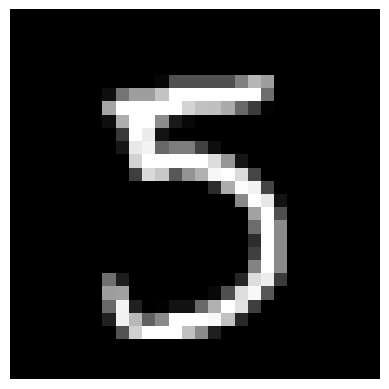

el valor predicho es: 5


In [36]:
idx = np.random.randint(len(y_test))
plot_number(x_test_num[idx])

pred = predict(x_test[idx].reshape(-1, 1))
print(f'el valor predicho es: {pred}')

In [37]:
import this # PEP 20

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!
